C:\Users\pc\AppData\Local\Temp\ipykernel_7232\1905354340.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


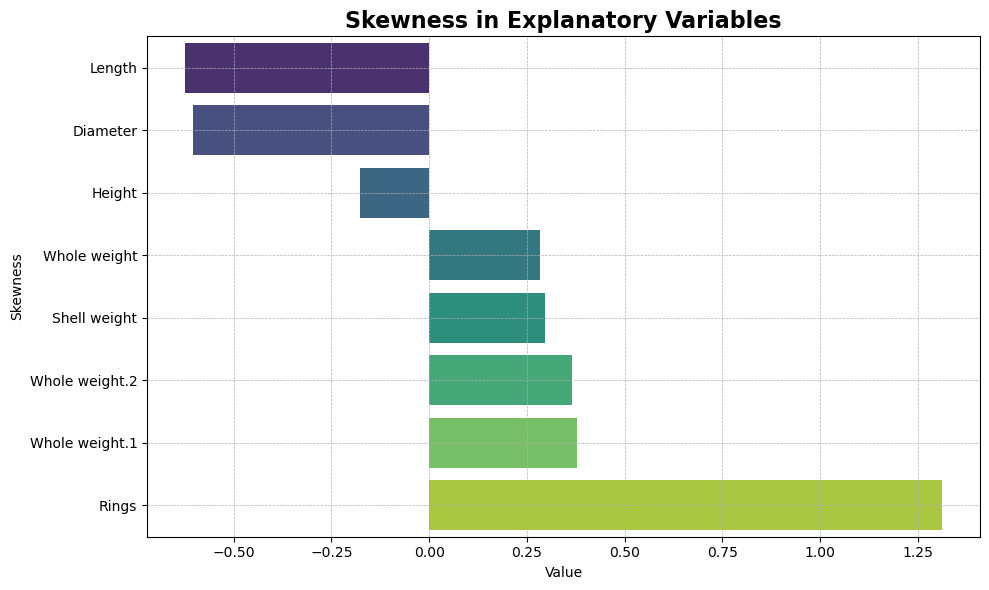

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("train_cleaned_sex_binary.csv")


numeric_cols = df.select_dtypes(include='number').columns.tolist()
for col_to_drop in ['id', 'Sex']:
    if col_to_drop in numeric_cols:
        numeric_cols.remove(col_to_drop)


skewness = df[numeric_cols].skew().sort_values()


plt.figure(figsize=(10, 6))
sns.barplot(
    x=skewness.values,
    y=skewness.index,
    palette="viridis"
)

plt.title("Skewness in Explanatory Variables", fontsize=16, weight='bold')
plt.xlabel("Value")
plt.ylabel("Skewness")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig("skewness_plot.png")
plt.show()


In [10]:
import pandas as pd
from openfe import OpenFE, transform
from openfe import tree_to_formula

df = pd.read_csv("train_cleaned_sex_binary.csv")

cols_to_drop = [col for col in ["Rings", "id"] if col in df.columns]
X = df.drop(columns=cols_to_drop)
y = df["Rings"]

ofe = OpenFE()
features = ofe.fit(data=X, label=y, n_jobs=4)

features = features[:10]

print("TOP-10：")
for f in features:
    print(" -", tree_to_formula(f))

X_new, _ = transform(X, pd.DataFrame(), features, n_jobs=4)

num_cols = X_new.shape[1]
base_names = [tree_to_formula(f) for f in features]
col_names = [f"f{i+1:02d}_{name}" for i, name in enumerate(base_names * ((num_cols // len(base_names)) + 1))]
X_new.columns = col_names[:num_cols]


df_new = pd.concat([X_new, y.reset_index(drop=True)], axis=1)











The number of candidate features is 322
Start stage I selection.


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.19it/s]


112 same features have been deleted.
Meet early-stopping in successive feature-wise halving.


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:22<00:00,  1.47s/it]


The number of remaining candidate features is 210
Start stage II selection.


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.20it/s]


Finish data processing.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42082
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 216
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
TOP-10：
 - (Length/Shell weight)
 - (Whole weight.1/Shell weight)
 - (Diameter/Shell weight)
 - (Whole weight/Whole weight.1)
 - (Length-Shell weight)
 - (Shell weight/Sex)
 - freq(Shell weight)
 - max(Whole weight.2,Shell weight)
 - max(Shell weight,Height)
 - (Shell weight+Height)


generate new ten features

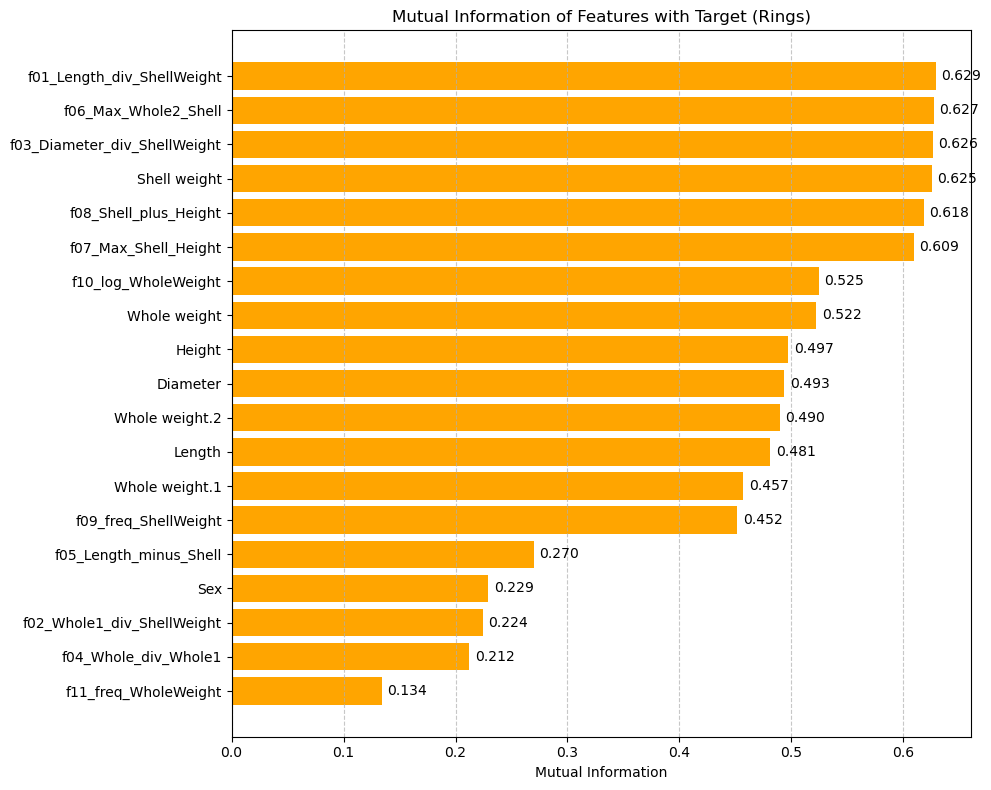

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression


def manual_openfe_features(df_raw):
    df = df_raw.copy()

    freq_shell = df["Shell weight"].value_counts(normalize=True)
    freq_whole = df["Whole weight"].value_counts(normalize=True)

    freq_feature_shell = df["Shell weight"].map(freq_shell)
    freq_feature_whole = df["Whole weight"].map(freq_whole)

    df_manual = pd.DataFrame({
        "f01_Length_div_ShellWeight": df["Length"] / (df["Shell weight"]),
        "f02_Whole1_div_ShellWeight": df["Whole weight.1"] / (df["Shell weight"]),
        "f03_Diameter_div_ShellWeight": df["Diameter"] / (df["Shell weight"]),
        "f04_Whole_div_Whole1": df["Whole weight"] / (df["Whole weight.1"]),
        "f05_Length_minus_Shell": df["Length"] - df["Shell weight"],
        "f06_Max_Whole2_Shell": df[["Whole weight.2", "Shell weight"]].max(axis=1),
        "f07_Max_Shell_Height": df[["Shell weight", "Height"]].max(axis=1),
        "f08_Shell_plus_Height": df["Shell weight"] + df["Height"],
        "f09_freq_ShellWeight": freq_feature_shell,
        "f10_log_WholeWeight": np.log(df["Whole weight"]),
        "f11_freq_WholeWeight": freq_feature_whole
    })

    return df_manual


df = pd.read_csv("train_cleaned_sex_binary.csv")
y = df["Rings"]


df_manual = manual_openfe_features(df)
original_features = df.select_dtypes(include='number').drop(columns=['id', 'Rings'], errors='ignore')
X_combined = pd.concat([original_features, df_manual], axis=1)


mi_scores = mutual_info_regression(X_combined, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X_combined.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)


plt.figure(figsize=(10, 8))
mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=True)
bars = plt.barh(mi_df_sorted['Feature'], mi_df_sorted['Mutual Information'], color='orange')


for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f'{width:.3f}', va='center')

plt.xlabel('Mutual Information')
plt.title('Mutual Information of Features with Target (Rings)')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.savefig("MI_score.png")
plt.show()


C:\Users\pc\AppData\Local\Temp\ipykernel_7232\3006597998.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['Sex'] = selected['Sex'].astype('category').cat.codes


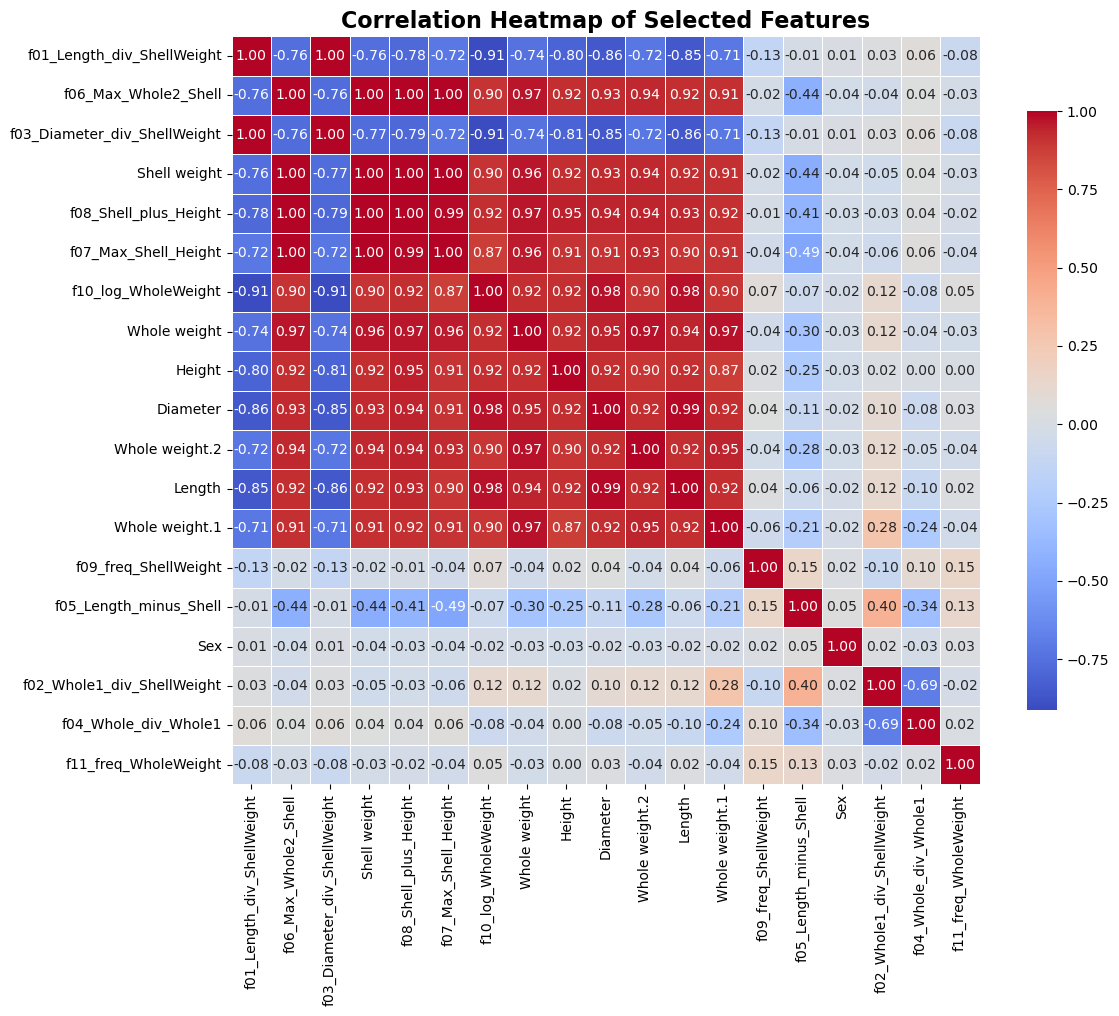

In [13]:
selected_features = [
    "f01_Length_div_ShellWeight",
    "f06_Max_Whole2_Shell",
    "f03_Diameter_div_ShellWeight",
    "Shell weight",
    "f08_Shell_plus_Height",
    "f07_Max_Shell_Height",
    "f10_log_WholeWeight",
    "Whole weight",
    "Height",
    "Diameter",
    "Whole weight.2",
    "Length",
    "Whole weight.1",
    "f09_freq_ShellWeight",
    "f05_Length_minus_Shell",
    "Sex",
    "f02_Whole1_div_ShellWeight",
    "f04_Whole_div_Whole1",
    "f11_freq_WholeWeight"
]
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("train_cleaned.csv")
df_manual = manual_openfe_features(df)


df_all = pd.concat([df, df_manual], axis=1)


selected = df_all[selected_features]


if 'Sex' in selected.columns:
    selected['Sex'] = selected['Sex'].astype('category').cat.codes


corr_matrix = selected.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap of Selected Features", fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig("selected_feature_correlation_heatmap.png", dpi=300)
plt.show()


Correlation with Rings:

f11_Shell_plus_Height           0.683130
Shell weight                    0.680125
f08_Max_Whole2_Shell            0.679609
Height                          0.651340
f09_log_Whole_weight            0.617797
Diameter                        0.607329
Whole weight                    0.599805
Length                          0.593042
Whole weight.2                  0.569188
Whole weight.1                  0.492409
f07_freq_ShellWeight            0.134552
f10_freq_WholeWeight            0.023768
f05_Length_minus_Shell         -0.382580
f01_Length_div_ShellWeight     -0.583181
f03_Diameter_div_ShellWeight   -0.585126
Name: Rings, dtype: float64


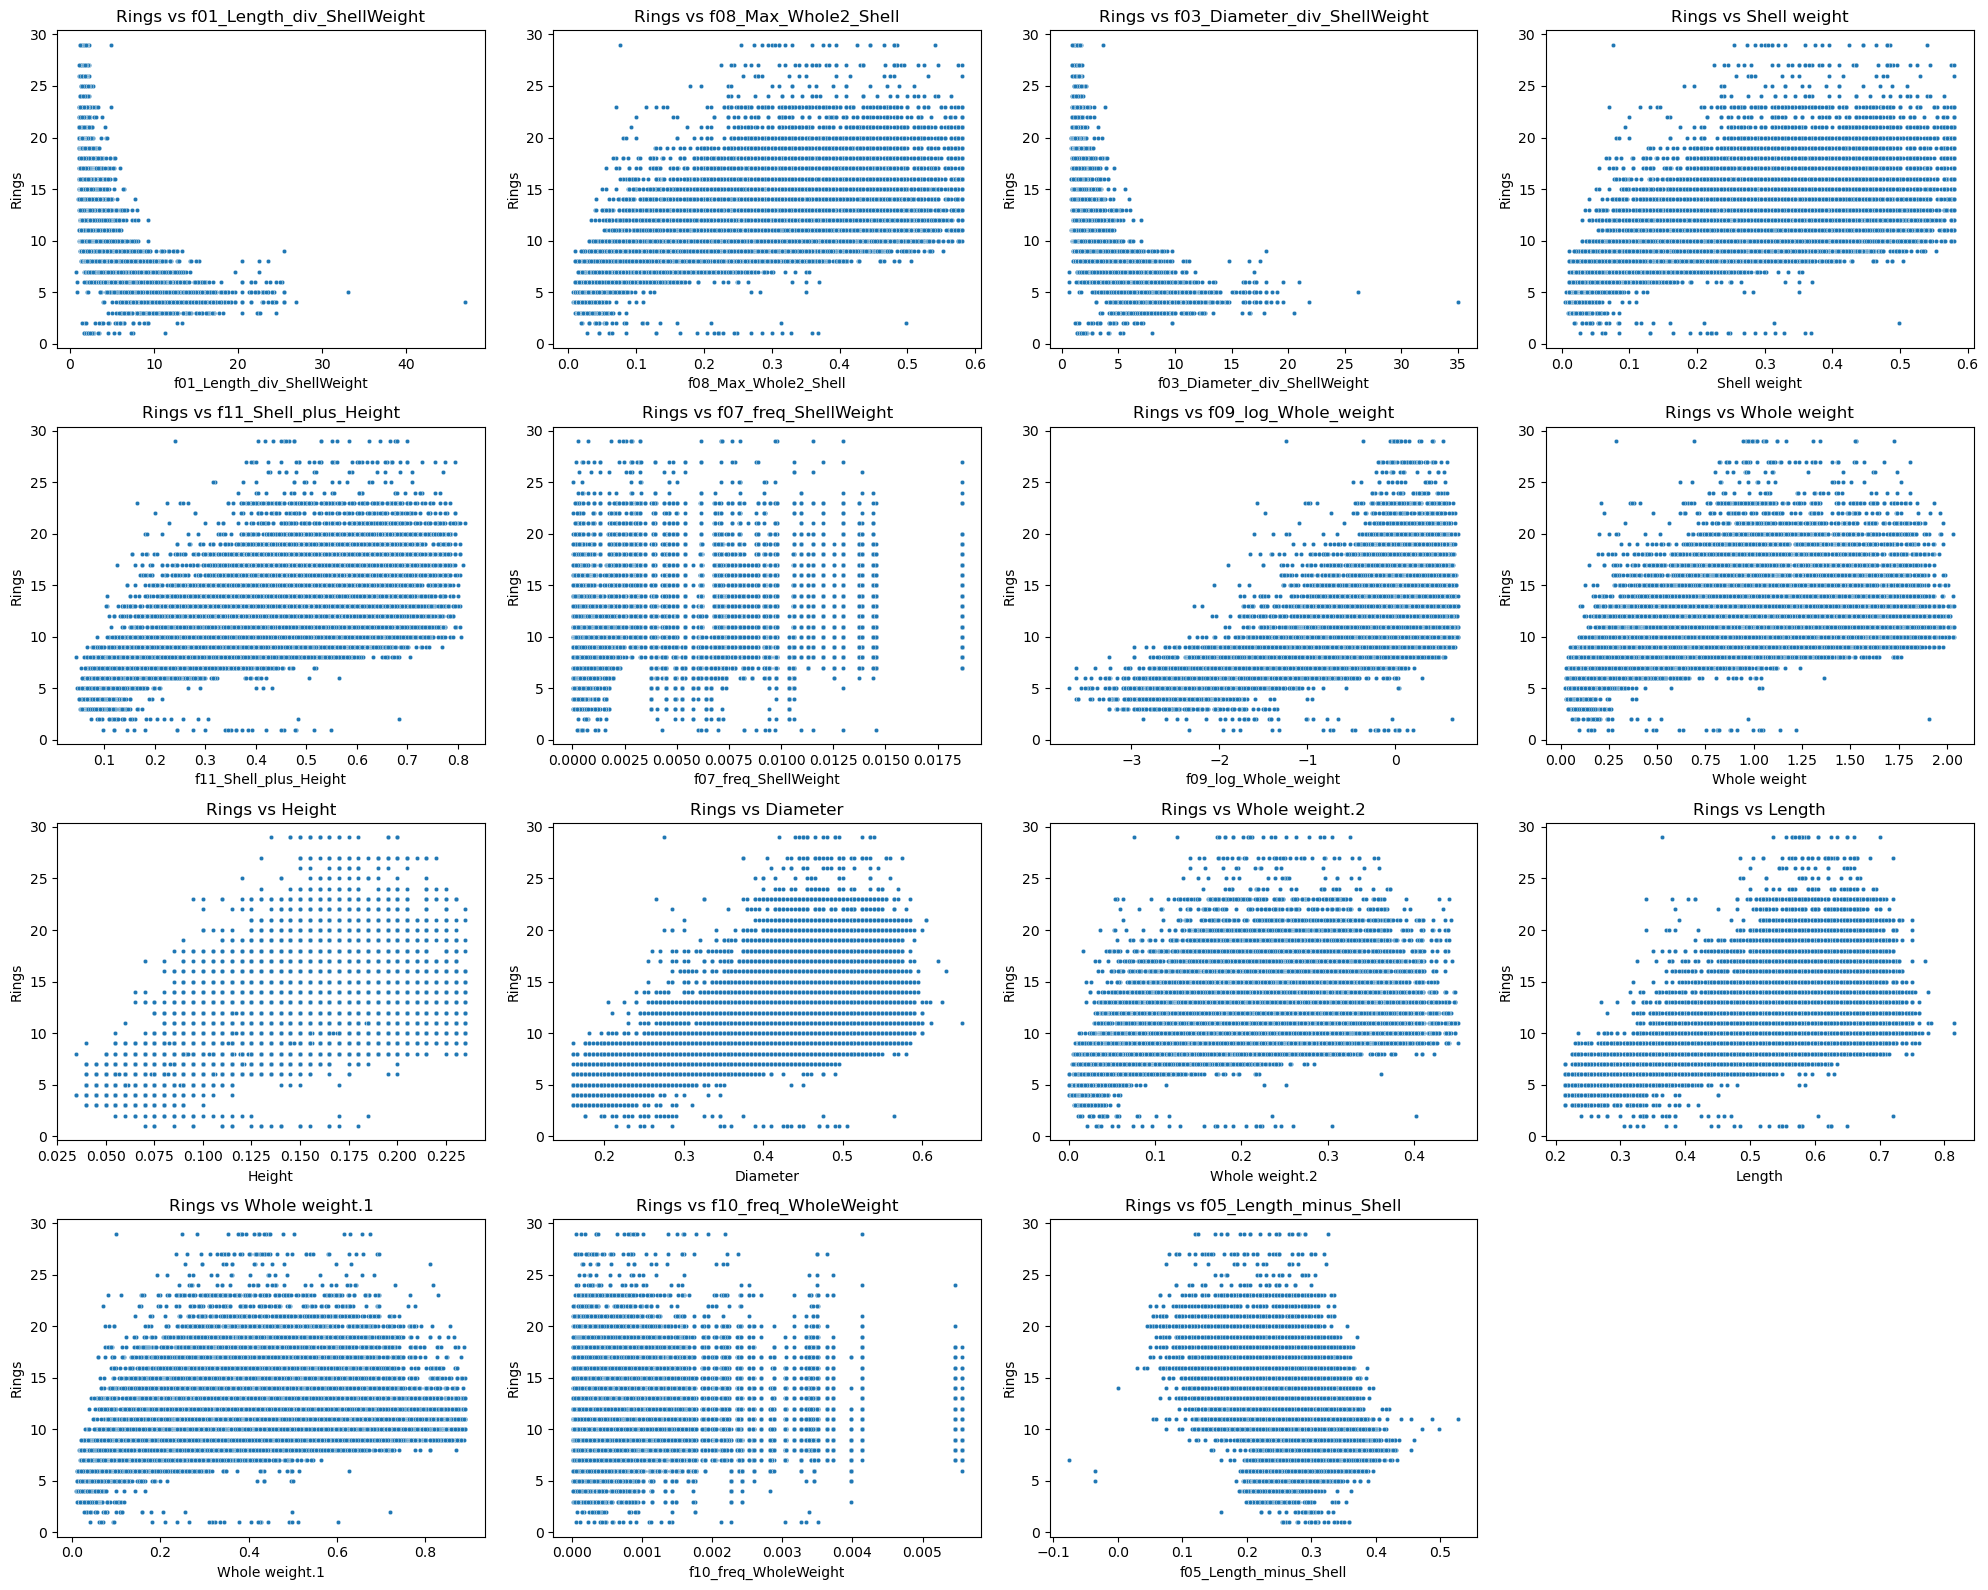

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def manual_openfe_features(df_raw):
    df = df_raw.copy()

    freq_shell = df["Shell weight"].value_counts(normalize=True)
    freq_whole = df["Whole weight"].value_counts(normalize=True)

    freq_feature_shell = df["Shell weight"].map(freq_shell)
    freq_feature_whole = df["Whole weight"].map(freq_whole)
    
    df_manual = pd.DataFrame({
        "f01_Length_div_ShellWeight": df["Length"] / (df["Shell weight"] ),
        "f02_Whole1_div_ShellWeight": df["Whole weight.1"] / (df["Shell weight"]),
        "f03_Diameter_div_ShellWeight": df["Diameter"] / (df["Shell weight"] ),
        "f05_Length_minus_Shell": df["Length"] - df["Shell weight"],
        "f07_freq_ShellWeight": freq_feature_shell,
        "f08_Max_Whole2_Shell": df[["Whole weight.2", "Shell weight"]].max(axis=1),
         "f09_log_Whole_weight": np.log(df["Whole weight"]),
        "f10_freq_WholeWeight": freq_feature_whole,
        "f11_Shell_plus_Height": df["Shell weight"] + df["Height"],
    })
    
    return df_manual
# 读取数据并手工构造特征
df = pd.read_csv("train_cleaned.csv")
df_manual = manual_openfe_features(df)  # 使用你之前定义的函数
df_all = pd.concat([df, df_manual], axis=1)

# 特征列表（从截图中提取）
selected_features = [
    "f01_Length_div_ShellWeight",
    "f08_Max_Whole2_Shell",
    "f03_Diameter_div_ShellWeight",
    "Shell weight",
    "f11_Shell_plus_Height",
    "f07_freq_ShellWeight",
    "f09_log_Whole_weight",
    "Whole weight",
    "Height",
    "Diameter",
    "Whole weight.2",
    "Length",
    "Whole weight.1",
    "f10_freq_WholeWeight",
    "f05_Length_minus_Shell"
]



if 'Sex' in df_all.columns:
    df_all['Sex'] = df_all['Sex'].astype('category').cat.codes


correlations = df_all[selected_features + ['Rings']].corr()
print("Correlation with Rings:\n")
print(correlations['Rings'].drop('Rings').sort_values(ascending=False))


ncols = 4
nrows = -(-len(selected_features) // ncols)  
plt.figure(figsize=(5 * ncols, 4 * nrows))

for i, feature in enumerate(selected_features):
    plt.subplot(nrows, ncols, i + 1)
    sns.scatterplot(data=df_all, x=feature, y='Rings', s=10)
    plt.title(f"Rings vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Rings")

plt.tight_layout()
plt.savefig("rings_vs_selected_features.png", dpi=300)
plt.show()
